In [1]:
from rdkit import Chem
from rdkit.Chem import Descriptors
import pandas as pd
import numpy as np
import random
import os
os.environ['R_HOME'] = 'C:\Programming\R\R-4.4.2'

In [2]:
# 재현성 난수 고정
SEED = 100

os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

random.seed(SEED)
np.random.seed(SEED)

In [3]:
# data load
df_name = 'esol'
df = pd.read_csv('C:\Programming\Github\EGCN\data\\' + df_name + '.csv')

smiles_list = df['smiles'].tolist()

# target 정의
target = df.iloc[:,-1]

print(smiles_list[:5])
print(target[:5])

['OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O', 'Cc1occc1C(=O)Nc2ccccc2', 'CC(C)=CCCC(C)=CC(=O)', 'c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43', 'c1ccsc1']
0   -0.77
1   -3.30
2   -2.06
3   -7.87
4   -1.33
Name: logp, dtype: float64


In [4]:
# 분자 특성 추출 class
class MolecularFeatureExtractor:
    def __init__(self):
        self.descriptors = [desc[0] for desc in Descriptors._descList]

    def extract_molecular_features(self, smiles_list):
        features_dict = {desc: [] for desc in self.descriptors}

        for smiles in smiles_list:
            mol = Chem.MolFromSmiles(smiles)
            if mol:
                for descriptor_name in self.descriptors:
                    descriptor_function = getattr(Descriptors, descriptor_name)
                    try:
                        features_dict[descriptor_name].append(descriptor_function(mol))
                    except:
                        features_dict[descriptor_name].append(None)
            else:
                for descriptor_name in self.descriptors:
                    features_dict[descriptor_name].append(None)

        return pd.DataFrame(features_dict)

In [5]:
# 분자 특성 추출 및 데이터프레임 정의
extractor = MolecularFeatureExtractor()
df_all_features = extractor.extract_molecular_features(smiles_list)

df_all_features['target'] = target
df_all_features.head()

MaxEStateIndex  MinEStateIndex  MaxAbsEStateIndex  MinAbsEStateIndex  \
0       10.253329       -1.701605          10.253329           0.486602   
1       11.724911       -0.145880          11.724911           0.145880   
2       10.020498        0.845090          10.020498           0.845090   
3        2.270278        1.301055           2.270278           1.301055   
4        2.041667        1.712963           2.041667           1.712963   

        qed    MolWt  HeavyAtomMolWt  ExactMolWt  NumValenceElectrons  \
0  0.217518  457.432         430.216  457.158411                  178   
1  0.811283  201.225         190.137  201.078979                   76   
2  0.343706  152.237         136.109  152.120115                   62   
3  0.291526  278.354         264.242  278.109550                  102   
4  0.448927   84.143          80.111   84.003371                   26   

   NumRadicalElectrons  ...  fr_sulfonamd  fr_sulfone  fr_term_acetylene  \
0                    0  ...             0           0                  0   
1                    0  ...             0           0                  0   
2                    0  ...             0           0                  0   
3                    0  ...             0           0                  0   
4                    0  ...             0           0                  0   

   fr_tetrazole  fr_thiazole  fr_thiocyan  fr_thiophene  fr_unbrch_alkane  \
0             0            0            0             0                 0   
1             0            0            0             0                 0   
2             0            0            0             0                 0   
3             0            0            0             0                 0   
4             0            0            0             1                 0   

   fr_urea  target  
0        0   -0.77  
1        0   -3.30  
2        0   -2.06  
3        0   -7.87  
4        0   -1.33  

[5 rows x 209 columns]

In [6]:
num_all_features = df_all_features.shape[1] - 1  # logvp 열 제외
print("초기 변수 개수:", num_all_features)

초기 변수 개수: 208


# 1. NA Handling

In [7]:
# NA 확인
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
df_all_features[df_all_features.isna().any(axis = 1)]

Empty DataFrame
Columns: [MaxEStateIndex, MinEStateIndex, MaxAbsEStateIndex, MinAbsEStateIndex, qed, MolWt, HeavyAtomMolWt, ExactMolWt, NumValenceElectrons, NumRadicalElectrons, MaxPartialCharge, MinPartialCharge, MaxAbsPartialCharge, MinAbsPartialCharge, FpDensityMorgan1, FpDensityMorgan2, FpDensityMorgan3, BCUT2D_MWHI, BCUT2D_MWLOW, BCUT2D_CHGHI, BCUT2D_CHGLO, BCUT2D_LOGPHI, BCUT2D_LOGPLOW, BCUT2D_MRHI, BCUT2D_MRLOW, BalabanJ, BertzCT, Chi0, Chi0n, Chi0v, Chi1, Chi1n, Chi1v, Chi2n, Chi2v, Chi3n, Chi3v, Chi4n, Chi4v, HallKierAlpha, Ipc, Kappa1, Kappa2, Kappa3, LabuteASA, PEOE_VSA1, PEOE_VSA10, PEOE_VSA11, PEOE_VSA12, PEOE_VSA13, PEOE_VSA14, PEOE_VSA2, PEOE_VSA3, PEOE_VSA4, PEOE_VSA5, PEOE_VSA6, PEOE_VSA7, PEOE_VSA8, PEOE_VSA9, SMR_VSA1, SMR_VSA10, SMR_VSA2, SMR_VSA3, SMR_VSA4, SMR_VSA5, SMR_VSA6, SMR_VSA7, SMR_VSA8, SMR_VSA9, SlogP_VSA1, SlogP_VSA10, SlogP_VSA11, SlogP_VSA12, SlogP_VSA2, SlogP_VSA3, SlogP_VSA4, SlogP_VSA5, SlogP_VSA6, SlogP_VSA7, SlogP_VSA8, SlogP_VSA9, TPSA, EState_VSA1, EState_VSA10, EState_VSA11, EState_VSA2, EState_VSA3, EState_VSA4, EState_VSA5, EState_VSA6, EState_VSA7, EState_VSA8, EState_VSA9, VSA_EState1, VSA_EState10, VSA_EState2, VSA_EState3, VSA_EState4, VSA_EState5, VSA_EState6, ...]
Index: []

In [8]:
# 결측치가 포함된 feature 개수
print('결측치가 포함된 열 개수:', df_all_features.isna().any(axis = 0).sum(), '\n')
print(df_all_features.isna().any(axis = 0))

결측치가 포함된 열 개수: 0 

MaxEStateIndex              False
MinEStateIndex              False
MaxAbsEStateIndex           False
MinAbsEStateIndex           False
qed                         False
MolWt                       False
HeavyAtomMolWt              False
ExactMolWt                  False
NumValenceElectrons         False
NumRadicalElectrons         False
MaxPartialCharge            False
MinPartialCharge            False
MaxAbsPartialCharge         False
MinAbsPartialCharge         False
FpDensityMorgan1            False
FpDensityMorgan2            False
FpDensityMorgan3            False
BCUT2D_MWHI                 False
BCUT2D_MWLOW                False
BCUT2D_CHGHI                False
BCUT2D_CHGLO                False
BCUT2D_LOGPHI               False
BCUT2D_LOGPLOW              False
BCUT2D_MRHI                 False
BCUT2D_MRLOW                False
BalabanJ                    False
BertzCT                     False
Chi0                        False
Chi0n                       F

In [9]:
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

In [10]:
# 결측치가 포함된 feature 제거
df_removed_features = df_all_features.dropna(axis = 1)
num_removed_features = df_removed_features.shape[1] - 1  # logvp 열 제외

print("제거 후 남은 feature 개수:", num_removed_features)

제거 후 남은 feature 개수: 208


In [11]:
# 결측치가 제거된 data frame
df_removed_features

MaxEStateIndex  MinEStateIndex  MaxAbsEStateIndex  MinAbsEStateIndex  \
0          10.253329       -1.701605          10.253329           0.486602   
1          11.724911       -0.145880          11.724911           0.145880   
2          10.020498        0.845090          10.020498           0.845090   
3           2.270278        1.301055           2.270278           1.301055   
4           2.041667        1.712963           2.041667           1.712963   
...              ...             ...                ...                ...   
1123       10.999421       -4.317901          10.999421           1.916667   
1124       11.337508       -0.705457          11.337508           0.123704   
1125        5.174287       -1.984662           5.174287           1.011373   
1126        2.222222        0.884259           2.222222           0.884259   
1127       11.888207       -3.753520          11.888207           0.016420   

           qed    MolWt  HeavyAtomMolWt  ExactMolWt  NumValenceElectrons  \
0     0.217518  457.432         430.216  457.158411                  178   
1     0.811283  201.225         190.137  201.078979                   76   
2     0.343706  152.237         136.109  152.120115                   62   
3     0.291526  278.354         264.242  278.109550                  102   
4     0.448927   84.143          80.111   84.003371                   26   
...        ...      ...             ...         ...                  ...   
1123  0.523506  197.381         196.373  195.890224                   44   
1124  0.293876  219.266         206.162  219.067762                   80   
1125  0.506070  246.359         231.239  245.997179                   74   
1126  0.444441   72.151          60.055   72.093900                   32   
1127  0.386625  365.964         356.892  363.899256                  106   

      NumRadicalElectrons  ...  fr_sulfonamd  fr_sulfone  fr_term_acetylene  \
0                       0  ...             0           0                  0   
1                       0  ...             0           0                  0   
2                       0  ...             0           0                  0   
3                       0  ...             0           0                  0   
4                       0  ...             0           0                  0   
...                   ...  ...           ...         ...                ...   
1123                    0  ...             0           0                  0   
1124                    0  ...             0           0                  0   
1125                    0  ...             0           0                  0   
1126                    0  ...             0           0                  0   
1127                    0  ...             0           0                  0   

      fr_tetrazole  fr_thiazole  fr_thiocyan  fr_thiophene  fr_unbrch_alkane  \
0                0            0            0             0                 0   
1                0            0            0             0                 0   
2                0            0            0             0                 0   
3                0            0            0             0                 0   
4                0            0            0             1                 0   
...            ...          ...          ...           ...               ...   
1123             0            0            0             0                 0   
1124             0            0            0             0                 0   
1125             0            0            0             0                 2   
1126             0            0            0             0                 0   
1127             0            0            0             0                 0   

      fr_urea  target  
0           0  -0.770  
1           0  -3.300  
2           0  -2.060  
3           0  -7.870  
4           0  -1.330  
...       ...     ...  
1123        0  -1.710  
1124        0   0.106  
1125        0  -3.091  
1126  

# 2. nunique == 1 인 경우

In [12]:
unique_columns = list(df_removed_features.loc[:, df_removed_features.nunique() == 1].columns)
print('nunique == 1인 feature : \n', unique_columns, '\n')

# nunique == 1인 feature 제거
#df_removed_features.drop(columns = unique_columns, inplace = True)
df_removed_features = df_removed_features.drop(columns = unique_columns).copy()

num_removed_features = df_removed_features.shape[1] - 1  # logvp 열 제외

print("제거 후 남은 feature 개수:", num_removed_features, '\n')
print(df_removed_features.shape)


nunique == 1인 feature : 
 ['NumRadicalElectrons', 'SMR_VSA8', 'SlogP_VSA9', 'fr_Al_COO', 'fr_Ar_COO', 'fr_COO', 'fr_COO2', 'fr_amidine', 'fr_azide', 'fr_diazo', 'fr_isocyan', 'fr_isothiocyan', 'fr_lactam', 'fr_morpholine', 'fr_nitroso', 'fr_prisulfonamd', 'fr_quatN', 'fr_tetrazole', 'fr_thiocyan'] 

제거 후 남은 feature 개수: 189 

(1128, 190)


In [13]:
df_removed_features

MaxEStateIndex  MinEStateIndex  MaxAbsEStateIndex  MinAbsEStateIndex  \
0          10.253329       -1.701605          10.253329           0.486602   
1          11.724911       -0.145880          11.724911           0.145880   
2          10.020498        0.845090          10.020498           0.845090   
3           2.270278        1.301055           2.270278           1.301055   
4           2.041667        1.712963           2.041667           1.712963   
...              ...             ...                ...                ...   
1123       10.999421       -4.317901          10.999421           1.916667   
1124       11.337508       -0.705457          11.337508           0.123704   
1125        5.174287       -1.984662           5.174287           1.011373   
1126        2.222222        0.884259           2.222222           0.884259   
1127       11.888207       -3.753520          11.888207           0.016420   

           qed    MolWt  HeavyAtomMolWt  ExactMolWt  NumValenceElectrons  \
0     0.217518  457.432         430.216  457.158411                  178   
1     0.811283  201.225         190.137  201.078979                   76   
2     0.343706  152.237         136.109  152.120115                   62   
3     0.291526  278.354         264.242  278.109550                  102   
4     0.448927   84.143          80.111   84.003371                   26   
...        ...      ...             ...         ...                  ...   
1123  0.523506  197.381         196.373  195.890224                   44   
1124  0.293876  219.266         206.162  219.067762                   80   
1125  0.506070  246.359         231.239  245.997179                   74   
1126  0.444441   72.151          60.055   72.093900                   32   
1127  0.386625  365.964         356.892  363.899256                  106   

      MaxPartialCharge  ...  fr_pyridine  fr_sulfide  fr_sulfonamd  \
0             0.188266  ...            0           0             0   
1             0.258698  ...            0           0             0   
2             0.142281  ...            0           0             0   
3            -0.009873  ...            0           0             0   
4            -0.009338  ...            0           0             0   
...                ...  ...          ...         ...           ...   
1123          0.414120  ...            0           0             0   
1124          0.432627  ...            0           1             0   
1125          0.246324  ...            0           1             0   
1126         -0.047395  ...            0           0             0   
1127          0.529073  ...            0           0             0   

      fr_sulfone  fr_term_acetylene  fr_thiazole  fr_thiophene  \
0              0                  0            0             0   
1              0                  0            0             0   
2              0                  0            0             0   
3              0                  0            0             0   
4              0                  0            0             1   
...          ...                ...          ...           ...   
1123           0                  0            0             0   
1124           0                  0            0             0   
1125           0                  0            0             0   
1126           0                  0            0             0   
1127           0                  0            0             0   

      fr_unbrch_alkane  fr_urea  target  
0                    0        0  -0.770  
1                    0        0  -3.300  
2                    0        0  -2.060  
3                    0        0  -7.870  
4                    0        0  -1.330  
...                ...      ...     ...  
1123                 0        0  -1.710  
1124                 0        0   0.106  
1125                 2        0  -3.091  
1126                 0        0  -3.180  
1127                 0        0  -4.522  

[1128 rows x 190 

# 3. 너무 낮은 variance를 가지는 경우

In [14]:
low_variances = sorted(df_removed_features.var())
low_variances[:10]

[0.0008865248226950355,
 0.0008865248226950355,
 0.0008865248226950357,
 0.0008865248226950358,
 0.0008865248226950358,
 0.0008865248226950359,
 0.0017714763981448273,
 0.0017714763981448273,
 0.002654854726349374,
 0.002654854726349374]

In [15]:
columns_low_variances = []

for i in low_variances:
    if i < 0.001:
        column = df_removed_features.loc[:, df_removed_features.var() == i].columns
        columns_low_variances.append(column)
columns_low_variances = [item for index in columns_low_variances for item in index]

# 2. 중복 제거 및 유니크 값 추출
columns_low_variances = list(set(columns_low_variances))
print(columns_low_variances)

['fr_hdrzone', 'fr_HOCCN', 'fr_dihydropyridine', 'fr_piperzine', 'fr_azo', 'fr_alkyl_carbamate']


In [16]:
# 낮은 분산의 변수 제거
df_removed_features = df_removed_features.drop(columns = columns_low_variances).copy()
num_removed_features = df_removed_features.shape[1] - 1  # logvp 열 제외

print("제거 후 남은 feature 개수:", num_removed_features, '\n')
print(df_removed_features.shape)

제거 후 남은 feature 개수: 183 

(1128, 184)


In [17]:
print("제거 후 남은 feature 개수:", num_removed_features, '\n')
print(df_removed_features.shape)

제거 후 남은 feature 개수: 183 

(1128, 184)


In [18]:
df_removed_features

MaxEStateIndex  MinEStateIndex  MaxAbsEStateIndex  MinAbsEStateIndex  \
0          10.253329       -1.701605          10.253329           0.486602   
1          11.724911       -0.145880          11.724911           0.145880   
2          10.020498        0.845090          10.020498           0.845090   
3           2.270278        1.301055           2.270278           1.301055   
4           2.041667        1.712963           2.041667           1.712963   
...              ...             ...                ...                ...   
1123       10.999421       -4.317901          10.999421           1.916667   
1124       11.337508       -0.705457          11.337508           0.123704   
1125        5.174287       -1.984662           5.174287           1.011373   
1126        2.222222        0.884259           2.222222           0.884259   
1127       11.888207       -3.753520          11.888207           0.016420   

           qed    MolWt  HeavyAtomMolWt  ExactMolWt  NumValenceElectrons  \
0     0.217518  457.432         430.216  457.158411                  178   
1     0.811283  201.225         190.137  201.078979                   76   
2     0.343706  152.237         136.109  152.120115                   62   
3     0.291526  278.354         264.242  278.109550                  102   
4     0.448927   84.143          80.111   84.003371                   26   
...        ...      ...             ...         ...                  ...   
1123  0.523506  197.381         196.373  195.890224                   44   
1124  0.293876  219.266         206.162  219.067762                   80   
1125  0.506070  246.359         231.239  245.997179                   74   
1126  0.444441   72.151          60.055   72.093900                   32   
1127  0.386625  365.964         356.892  363.899256                  106   

      MaxPartialCharge  ...  fr_pyridine  fr_sulfide  fr_sulfonamd  \
0             0.188266  ...            0           0             0   
1             0.258698  ...            0           0             0   
2             0.142281  ...            0           0             0   
3            -0.009873  ...            0           0             0   
4            -0.009338  ...            0           0             0   
...                ...  ...          ...         ...           ...   
1123          0.414120  ...            0           0             0   
1124          0.432627  ...            0           1             0   
1125          0.246324  ...            0           1             0   
1126         -0.047395  ...            0           0             0   
1127          0.529073  ...            0           0             0   

      fr_sulfone  fr_term_acetylene  fr_thiazole  fr_thiophene  \
0              0                  0            0             0   
1              0                  0            0             0   
2              0                  0            0             0   
3              0                  0            0             0   
4              0                  0            0             1   
...          ...                ...          ...           ...   
1123           0                  0            0             0   
1124           0                  0            0             0   
1125           0                  0            0             0   
1126           0                  0            0             0   
1127           0                  0            0             0   

      fr_unbrch_alkane  fr_urea  target  
0                    0        0  -0.770  
1                    0        0  -3.300  
2                    0        0  -2.060  
3                    0        0  -7.870  
4                    0        0  -1.330  
...                ...      ...     ...  
1123                 0        0  -1.710  
1124                 0        0   0.106  
1125                 2        0  -3.091  
1126                 0        0  -3.180  
1127                 0        0  -4.522  

[1128 rows x 184 

# 4. 데이터 스크리닝 (ISIS)

In [19]:
X_train = df_removed_features.drop(columns = 'target')
y_train = df_removed_features['target']

print(X_train.shape)
print(y_train.shape)

(1128, 183)
(1128,)


In [20]:
# 스케일링
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaling = scaler.transform(X_train)
print(X_train_scaling.shape)

(1128, 183)


In [21]:
# Python to R type
from rpy2.robjects import r
from rpy2.robjects import pandas2ri
from rpy2.robjects import FloatVector

pandas2ri.activate()

X_train_scaling = r['as.matrix'](X_train_scaling)

y_train = FloatVector(y_train)

nfolds = 10
nfolds = FloatVector([nfolds])[0]

nsis = 100
nsis = FloatVector([nsis])[0]

seed = 9
seed = FloatVector([seed])[0]

In [22]:
from rpy2.robjects.packages import importr
import sys
import io

SIS = importr('SIS')

# R 출력이 발생할 때 UTF-8 오류를 방지하기 위해, 표준 출력을 임시로 바꿔서 처리할 수 있습니다.
#r('Sys.setlocale("LC_ALL", "C.UTF-8")')

# model1 = SIS(...)
model1 = SIS.SIS(X_train_scaling,y_train,
    family="gaussian",
#    penalty="MCP",
    tune="cv",
    nfolds=nfolds,
    nsis=nsis,
    varISIS="aggr",
    seed=seed,
    q = 0.95,
    standardize=False)


Iter 1 , screening:  6 7 8 9 11 12 14 15 18 19 20 21 23 25 26 27 28 29 30 31 32 33 34 35 36 37 38 41 42 44 55 56 58 60 66 67 71 75 76 77 78 83 84 86 89 90 92 97 101 102 103 105 108 110 112 114 118 119 120 146 148 154 
Iter 1 , selection:  12 14 18 19 25 26 34 60 67 76 83 86 89 101 103 114 118 119 148 
Iter 1 , conditional-screening:  1 3 7 9 11 13 16 22 30 32 33 37 39 45 49 57 64 66 69 71 79 90 92 102 104 108 111 112 113 120 125 126 127 128 137 142 144 145 146 150 155 156 158 159 163 168 170 171 
Iter 2 , screening:  1 3 7 9 11 12 13 14 16 18 19 22 25 26 30 32 33 34 37 39 45 49 57 60 64 66 67 69 71 76 79 83 86 89 90 92 101 102 103 104 108 111 112 113 114 118 119 120 125 126 127 128 137 142 144 145 146 148 150 155 156 158 159 163 168 170 171 
Iter 2 , selection:  1 12 13 14 18 19 25 26 49 57 60 67 69 83 86 89 103 114 119 125 126 144 145 148 150 155 156 163 168 171 
Iter 2 , conditional-screening:  3 6 7 8 9 10 11 22 27 28 29 30 35 36 37 38 39 41 42 44 54 56 74 76 77 82 90 92 97 102 104 

In [23]:
print(str(model1))

$sis.ix0
 [1]   6   7   8   9  11  12  14  15  18  19  20  21  23  25  26  27  28  29  30
[20]  31  32  33  34  35  36  37  38  41  42  44  55  56  58  60  66  67  71  75
[39]  76  77  78  83  84  86  89  90  92  97 101 102 103 105 108 110 112 114 118
[58] 119 120 146 148 154

$ix
 [1]   1  12  13  15  18  19  25  42  49  57  58  60  67  68  69  74  77  81  82
[20]  83  86  89 101 109 117 119 122 125 127 131 140 142 144 145 148 150 152 155
[39] 156 157 165 168 171

$coef.est
(Intercept)          X1         X12         X13         X15         X18 
-3.05010195  0.33693980  0.35486792 -0.30261581  0.11128513  0.34690728 
        X19         X25         X42         X49         X57         X58 
-0.24294634  0.23427769 -0.23646381 -0.15421641  0.17840983  0.11992044 
        X60         X67         X68         X69         X74         X77 
-0.43974420 -0.11191920 -0.24048891 -0.13131129 -0.09097920 -0.08486568 
        X81         X82         X83         X86         X89        X101 
-0.170888

In [24]:
print(df_removed_features.shape)
print('\n')
print(df_removed_features.columns)


(1128, 184)


Index(['MaxEStateIndex', 'MinEStateIndex', 'MaxAbsEStateIndex',
       'MinAbsEStateIndex', 'qed', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt',
       'NumValenceElectrons', 'MaxPartialCharge',
       ...
       'fr_pyridine', 'fr_sulfide', 'fr_sulfonamd', 'fr_sulfone',
       'fr_term_acetylene', 'fr_thiazole', 'fr_thiophene', 'fr_unbrch_alkane',
       'fr_urea', 'target'],
      dtype='object', length=184)


In [25]:
# 선택된 feature들의 index
selected_features_ISIS = np.array(model1.rx2('ix'))

# R은 index가 1부터 시작하므로 python에 맞게 보정
selected_features_ISIS = selected_features_ISIS - 1
selected_features_ISIS

array([  0,  11,  12,  14,  17,  18,  24,  41,  48,  56,  57,  59,  66,
        67,  68,  73,  76,  80,  81,  82,  85,  88, 100, 108, 116, 118,
       121, 124, 126, 130, 139, 141, 143, 144, 147, 149, 151, 154, 155,
       156, 164, 167, 170])

In [26]:
df_removed_features_columns = df_removed_features.columns
print(f'ISIS 적용 전 features: {df_removed_features_columns.size}개')
print(df_removed_features_columns, '\n')

selected_features = df_removed_features_columns[selected_features_ISIS]
print(f'ISIS 적용 후 features: {selected_features.size}개')
print(selected_features)

ISIS 적용 전 features: 184개
Index(['MaxEStateIndex', 'MinEStateIndex', 'MaxAbsEStateIndex',
       'MinAbsEStateIndex', 'qed', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt',
       'NumValenceElectrons', 'MaxPartialCharge',
       ...
       'fr_pyridine', 'fr_sulfide', 'fr_sulfonamd', 'fr_sulfone',
       'fr_term_acetylene', 'fr_thiazole', 'fr_thiophene', 'fr_unbrch_alkane',
       'fr_urea', 'target'],
      dtype='object', length=184) 

ISIS 적용 후 features: 43개
Index(['MaxEStateIndex', 'MaxAbsPartialCharge', 'MinAbsPartialCharge',
       'FpDensityMorgan2', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BalabanJ',
       'Kappa2', 'PEOE_VSA13', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA10',
       'SMR_VSA9', 'SlogP_VSA1', 'SlogP_VSA10', 'SlogP_VSA4', 'SlogP_VSA7',
       'EState_VSA10', 'EState_VSA11', 'EState_VSA2', 'EState_VSA5',
       'EState_VSA8', 'FractionCSP3', 'NumAromaticHeterocycles',
       'NumSaturatedRings', 'MolLogP', 'fr_Al_OH_noTert', 'fr_Ar_NH', 'fr_C_O',
       'fr_NH0', 'fr_alkyl_halide', 'f

In [27]:
df_ISIS = df_removed_features[list(selected_features) + ['target']]
df_ISIS

MaxEStateIndex  MaxAbsPartialCharge  MinAbsPartialCharge  \
0          10.253329             0.393567             0.188266   
1          11.724911             0.468799             0.258698   
2          10.020498             0.298566             0.142281   
3           2.270278             0.061629             0.009873   
4           2.041667             0.152454             0.009338   
...              ...                  ...                  ...   
1123       10.999421             0.414120             0.168387   
1124       11.337508             0.432627             0.342862   
1125        5.174287             0.325040             0.246324   
1126        2.222222             0.065138             0.047395   
1127       11.888207             0.529073             0.402377   

      FpDensityMorgan2  BCUT2D_MWLOW  BCUT2D_CHGHI  BalabanJ     Kappa2  \
0             1.375000      9.980560      2.475238  1.654937  10.926356   
1             1.933333     10.209837      2.102137  2.148162   4.002882   
2             1.909091     10.117402      1.860315  3.625760   5.899351   
3             0.636364      9.942879      2.059971  2.041379   4.315741   
4             1.600000     10.690499      1.581286  3.125000   1.221050   
...                ...           ...           ...       ...        ...   
1123          1.571429     10.789233      2.352344  3.541197   2.218900   
1124          2.000000     10.594724      2.133809  4.399366   6.249700   
1125          1.833333     10.948494      2.142743  3.522395   7.653224   
1126          1.600000     10.164169      1.795310  2.539539   2.250000   
1127          1.631579     10.175646      2.271357  3.195069   7.185363   

      PEOE_VSA13  PEOE_VSA8  ...  fr_bicyclic  fr_ester  fr_furan  fr_hdrzine  \
0        0.00000   0.000000  ...            0         0         0           0   
1        5.90718   5.687386  ...            0         0         1           0   
2        0.00000   0.000000  ...            0         0         0           0   
3        0.00000   0.000000  ...            7         0         0           0   
4        0.00000   0.000000  ...            0         0         0           0   
...          ...        ...  ...          ...       ...       ...         ...   
1123     0.00000   0.000000  ...            0         0         0           0   
1124     5.90718  21.143016  ...            0         0         0           0   
1125     0.00000  25.725302  ...            0         0         0           0   
1126     0.00000   0.000000  ...            0         0         0           0   
1127     0.00000  25.318249  ...            0         0         0           0   

      fr_imidazole  fr_imide  fr_nitro_arom_nonortho  fr_para_hydroxylation  \
0                0         0                       0                      0   
1                0         0                       0                      1   
2                0         0                       0                      0   
3                0         0                       0                      0   
4                0         0                       0                      0   
...            ...       ...                     ...                    ...   
1123             0         0                       0                      0   
1124             0         0                       0                      0   
1125             0         0                       0                      0   
1126             0         0                       0                      0   
1127             0         0                       0                      0   

      fr_phos_acid  target  
0                0  -0.770  
1                0  -3.300  
2                0  -2.060  
3                0  -7.870  
4                0  -1.330  
...            ...     ...  
1123             0  -1.710  
1124             0   0.106  
1125             0  -3.091  
1126             0  -3.180  
1127             1  -4.522  

[1128 rows x 44 columns]

# 5. 엘라스틱 넷

In [28]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE

In [29]:
X_ISIS = df_ISIS.drop(columns = ['target'])
y_ISIS = df_ISIS['target']

# train / test split
X_train, X_test, y_train, y_test = train_test_split(X_ISIS, y_ISIS, test_size = 0.2, random_state = SEED)

# scaling
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaling = scaler.transform(X_train)
X_test_scaling = scaler.transform(X_test)

print(X_train_scaling.shape)
print(X_test_scaling.shape)

(902, 43)
(226, 43)


In [30]:
# ElasticNet 모델과 하이퍼파라미터 범위 설정
elastic_net = ElasticNet(max_iter = 5000)
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0],  # 정규화 강도
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9, 1.0]  # L1과 L2 비율
}

kfold = KFold(n_splits = 5, shuffle = True, random_state = SEED)

# GridSearchCV를 사용하여 최적 하이퍼파라미터 탐색
grid_search = GridSearchCV(
    estimator = elastic_net,
    param_grid = param_grid,
    scoring = 'neg_mean_squared_error',
    cv = kfold,
    verbose = 1,
    n_jobs = -1
)

grid_search.fit(X_train_scaling, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=ElasticNet(max_iter=5000), n_jobs=-1,
             param_grid={'alpha': [0.001, 0.01, 0.1, 1.0, 10.0],
                         'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9, 1.0]},
             scoring='neg_mean_squared_error', verbose=1)

In [31]:
best_params = grid_search.best_params_
print(best_params)

{'alpha': 0.001, 'l1_ratio': 0.1}


In [32]:
# 최적 하이퍼파라미터로 ElasticNet 모델 생성
best_params = grid_search.best_params_

best_elastic_net = ElasticNet(
    alpha = best_params['alpha'],
    l1_ratio = best_params['l1_ratio'],
    max_iter = 5000,
    fit_intercept=True
)

In [33]:
X_train

MaxEStateIndex  MaxAbsPartialCharge  MinAbsPartialCharge  \
606         2.157407             0.061629             0.015474   
1095       12.119726             0.507679             0.173909   
147        11.787878             0.327632             0.276823   
416        10.147315             0.393168             0.291601   
807        11.929105             0.385668             0.354393   
...              ...                  ...                  ...   
802         8.466435             0.393579             0.105123   
53         11.706829             0.328350             0.310185   
350         8.055556             0.393707             0.048348   
79          6.374304             0.341622             0.216672   
792         9.965856             0.388650             0.166770   

      FpDensityMorgan2  BCUT2D_MWLOW  BCUT2D_CHGHI  BalabanJ    Kappa2  \
606           1.545455     10.065658      1.914937  2.913161  2.387075   
1095          1.714286      9.950554      2.306027  2.013923  4.588187   
147           1.625000      9.761311      2.477714  2.871702  4.634243   
416           2.000000     10.268054      2.065199  3.152941  2.344994   
807           1.904762     10.093468      2.212646  3.229205  7.556273   
...                ...           ...           ...       ...       ...   
802           1.125000     10.220835      2.116841  3.292478  3.795331   
53            2.071429     10.238233      2.120450  3.529082  4.125446   
350           1.500000     10.503602      1.688227  2.323790  1.297838   
79            2.272727     10.055659      2.445587  1.956624  6.542256   
792           1.470588      9.830510      2.828212  2.317184  3.435920   

      PEOE_VSA13  PEOE_VSA8  ...  fr_barbitur  fr_bicyclic  fr_ester  \
606     0.000000   0.000000  ...            0            1         0   
1095    0.000000  12.132734  ...            0            1         0   
147     0.000000   0.000000  ...            1            0         0   
416     5.687386   6.066367  ...            0            0         0   
807     0.000000  31.897480  ...            0            0         0   
...          ...        ...  ...          ...          ...       ...   
802     0.000000   0.000000  ...            0            0         0   
53      5.559267  11.735769  ...            0            0         0   
350     0.000000   6.103966  ...            0            0         0   
79      0.000000  10.586085  ...            0            0         0   
792     0.000000  11.835812  ...            0            5         0   

      fr_furan  fr_hdrzine  fr_imidazole  fr_imide  fr_nitro_arom_nonortho  \
606          0           0             0         0                       0   
1095         0           0             0         0                       0   
147          0           0             0         2                       0   
416          0           0             0         0                       0   
807          0           0             0         0                       0   
...        ...         ...           ...       ...                     ...   
802          0           0             0         0                       0   
53           0           0             0         0                       0   
350          0           0             0         0                       0   
79           0           0             0         0                       0   
792          0           0             0         0                       0   

      fr_para_hydroxylation  fr_phos_acid  
606                       0             0  
1095                      0             0  
147                       0             0  
416                       2             0  
807                       0             0  
...                     ...           ...  
802                       0             0  
53                        0             0  
350                       0             0  
79                        0             0  
792                       0           

In [34]:
# 학습
best_elastic_net.fit(X_train_scaling, y_train)

# 회귀 계수
coefficients = best_elastic_net.coef_

# feature와 계수 매핑
final_selected_features = pd.DataFrame({'Feature' : X_train.columns,
                                       'Coefficient' : coefficients})
# 계수
final_selected_features = abs(final_selected_features['Coefficient']).sort_values(ascending = False)
final_selected_features_index = final_selected_features.index
final_selected_features_index

Index([25, 11,  0,  1,  5,  4, 39,  7,  2, 23, 13, 31,  6, 27,  9, 24, 29,  8,
       33, 30, 28, 34, 35, 10, 26, 14, 18, 38, 17, 20, 12, 22,  3, 36, 37, 32,
       21, 42, 16, 15, 19, 40, 41],
      dtype='int64')

In [35]:
final_selected_features_index.size

43

In [36]:
# 최종 변수 출력
num_features = [3, 5, 7, 10, 20]
dfs = {}

for i in num_features:
    print(f'변수 {i}개: ', list(X_train.columns[final_selected_features_index[: i]]), '\n')
    dfs[f'df_name_{i}'] = list(X_train.columns[final_selected_features_index[: i]])

변수 3개:  ['MolLogP', 'SMR_VSA10', 'MaxEStateIndex'] 

변수 5개:  ['MolLogP', 'SMR_VSA10', 'MaxEStateIndex', 'MaxAbsPartialCharge', 'BCUT2D_CHGHI'] 

변수 7개:  ['MolLogP', 'SMR_VSA10', 'MaxEStateIndex', 'MaxAbsPartialCharge', 'BCUT2D_CHGHI', 'BCUT2D_MWLOW', 'fr_imide'] 

변수 10개:  ['MolLogP', 'SMR_VSA10', 'MaxEStateIndex', 'MaxAbsPartialCharge', 'BCUT2D_CHGHI', 'BCUT2D_MWLOW', 'fr_imide', 'Kappa2', 'MinAbsPartialCharge', 'NumAromaticHeterocycles'] 

변수 20개:  ['MolLogP', 'SMR_VSA10', 'MaxEStateIndex', 'MaxAbsPartialCharge', 'BCUT2D_CHGHI', 'BCUT2D_MWLOW', 'fr_imide', 'Kappa2', 'MinAbsPartialCharge', 'NumAromaticHeterocycles', 'SlogP_VSA1', 'fr_amide', 'BalabanJ', 'fr_Ar_NH', 'PEOE_VSA8', 'NumSaturatedRings', 'fr_NH0', 'PEOE_VSA13', 'fr_barbitur', 'fr_alkyl_halide'] 



In [37]:
best_elastic_net.coef_.size 

43

## OLS 적합 (p-value 사용)

In [38]:
import statsmodels.api as sm

X_selected = X_train.iloc[:, best_elastic_net.coef_ != 0]  # 계수가 0이 아닌 변수만 선택
ols_model = sm.OLS(y_train, X_selected).fit()

ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 target   R-squared (uncentered):                   0.972
Model:                            OLS   Adj. R-squared (uncentered):              0.970
Method:                 Least Squares   F-statistic:                              686.1
Date:                   수, 04 12 2024   Prob (F-statistic):                        0.00
Time:                        12:33:37   Log-Likelihood:                         -850.69
No. Observations:                 902   AIC:                                      1787.
Df Residuals:                     859   BIC:                                      1994.
Df Model:                          43                                                  
Covariance Type:            nonrobust                                                  
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
MaxEStateIndex              0.1004      0.015      6.693      0.000       0.071       0.130
MaxAbsPartialCharge         2.5695      0.263      9.768      0.000       2.053       3.086
MinAbsPartialCharge        -1.5687      0.409     -3.837      0.000      -2.371      -0.766
FpDensityMorgan2            0.1603      0.066      2.445      0.015       0.032       0.289
BCUT2D_MWLOW                0.0755      0.023      3.309      0.001       0.031       0.120
BCUT2D_CHGHI               -1.8563      0.149    -12.434      0.000      -2.149      -1.563
BalabanJ                    0.3353      0.057      5.854      0.000       0.223       0.448
Kappa2                     -0.1220      0.021     -5.673      0.000      -0.164      -0.080
PEOE_VSA13                 -0.0582      0.010     -5.714      0.000      -0.078      -0.038
PEOE_VSA8                   0.0213      0.004      6.025      0.000       0.014       0.028
PEOE_VSA9                   0.0154      0.004      3.518      0.000       0.007       0.024
SMR_VSA10                  -0.0147      0.003     -5.490      0.000      -0.020      -0.009
SMR_VSA9                   -0.0197      0.006     -3.157      0.002      -0.032      -0.007
SlogP_VSA1                 -0.0630      0.010     -6.519      0.000      -0.082      -0.044
SlogP_VSA10                -0.0223      0.009     -2.617      0.009      -0.039      -0.006
SlogP_VSA4                 -0.0060      0.005     -1.309      0.191      -0.015       0.003
SlogP_VSA7                 -0.0170      0.008     -2.122      0.034      -0.033      -0.001
EState_VSA10               -0.0143      0.007     -2.059      0.040      -0.028      -0.001
EState_VSA11               -0.2342      0.050     -4.693      0.000      -0.332      -0.136
EState_VSA2                 0.0084      0.004      2.265      0.024       0.001       0.016
EState_VSA5                -0.0093      0.002     -4.409      0.000      -0.013      -0.005
EState_VSA8                -0.0060      0.002     -2.644      0.008      -0.010      -0.002
FractionCSP3                0.4169      0.093      4.475      0.000       0.234       0.600
NumAromaticHeterocycles     0.5241      0.091      5.748      0.000       0.345       0.703
NumSaturatedRings           0.1779      0.054      3.318      0.001       0.073       0.283
MolLogP                    -0.6853      0.041    -16.645      0.000      -0.766      -0.604
fr_Al_OH_noTert            -0.1875      0.054     -3.455      0.001      -0.294      -0.081
fr_Ar_NH                   -0.8254      0.113     -7.335      0.000      -1.046      -0.605
fr_C_O                      0.0839      0.072      1.160      0.247      -0.058       0.226
fr_NH0                     -0.1539      

In [39]:
df_coef = pd.DataFrame({'coef' : ols_model.params,
                        'pvalue' : ols_model.pvalues,
                        'abs_coef' : abs(ols_model.params)})
df_coef = df_coef[df_coef['pvalue'] <= 0.05]
df_coef = df_coef.sort_values(by = ['pvalue', 'abs_coef'], ascending = [True, False])

print(list(df_coef.index))
print(len(list(df_coef.index)))


['MolLogP', 'BCUT2D_CHGHI', 'MaxAbsPartialCharge', 'fr_Ar_NH', 'MaxEStateIndex', 'SlogP_VSA1', 'PEOE_VSA8', 'BalabanJ', 'NumAromaticHeterocycles', 'PEOE_VSA13', 'Kappa2', 'SMR_VSA10', 'fr_phos_acid', 'EState_VSA11', 'fr_alkyl_halide', 'fr_imidazole', 'fr_hdrzine', 'FractionCSP3', 'EState_VSA5', 'fr_furan', 'MinAbsPartialCharge', 'fr_ester', 'PEOE_VSA9', 'fr_amide', 'fr_Al_OH_noTert', 'fr_imide', 'fr_aryl_methyl', 'fr_NH0', 'NumSaturatedRings', 'BCUT2D_MWLOW', 'fr_bicyclic', 'SMR_VSA9', 'EState_VSA8', 'SlogP_VSA10', 'fr_para_hydroxylation', 'FpDensityMorgan2', 'EState_VSA2', 'SlogP_VSA7', 'fr_nitro_arom_nonortho', 'EState_VSA10', 'fr_barbitur']
41


In [40]:
print(X_selected.columns[ols_model.pvalues <= 0.05])
print(X_selected.columns[ols_model.pvalues <= 0.05].size)


Index(['MaxEStateIndex', 'MaxAbsPartialCharge', 'MinAbsPartialCharge',
       'FpDensityMorgan2', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BalabanJ',
       'Kappa2', 'PEOE_VSA13', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA10',
       'SMR_VSA9', 'SlogP_VSA1', 'SlogP_VSA10', 'SlogP_VSA7', 'EState_VSA10',
       'EState_VSA11', 'EState_VSA2', 'EState_VSA5', 'EState_VSA8',
       'FractionCSP3', 'NumAromaticHeterocycles', 'NumSaturatedRings',
       'MolLogP', 'fr_Al_OH_noTert', 'fr_Ar_NH', 'fr_NH0', 'fr_alkyl_halide',
       'fr_amide', 'fr_aryl_methyl', 'fr_barbitur', 'fr_bicyclic', 'fr_ester',
       'fr_furan', 'fr_hdrzine', 'fr_imidazole', 'fr_imide',
       'fr_nitro_arom_nonortho', 'fr_para_hydroxylation', 'fr_phos_acid'],
      dtype='object')
41


## permutation importance (사용 X)

In [41]:
# from sklearn.inspection import permutation_importance

# threshold = 0.005

# result = permutation_importance(best_elastic_net, X_test_scaling, y_test, random_state = SEED)

# importances = result.importances_mean
# sorted_idx = importances.argsort()[::-1]

# threshold_selected_features = X_train.columns[sorted_idx]
# threshold_selected_features = threshold_selected_features[importances[sorted_idx] >  threshold]
# print(list(threshold_selected_features))
# print(threshold_selected_features.size)


# 예측

In [42]:
y_pred = best_elastic_net.predict(X_test_scaling)

In [43]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

print(mean_squared_error(y_test, y_pred))
print(r2_score(y_test, y_pred))


0.45963317676980925
0.9054839703273211


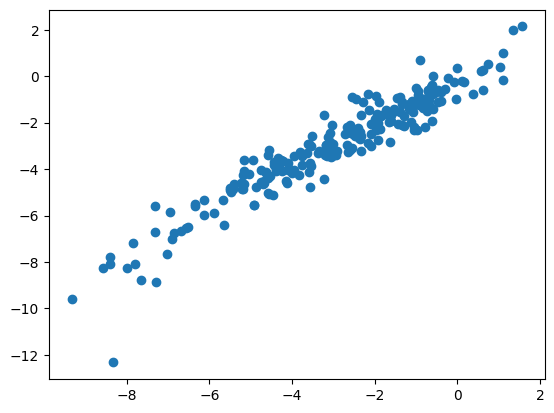

In [44]:
import matplotlib.pyplot as plt
plt.scatter(y_test, y_pred)
plt.show()

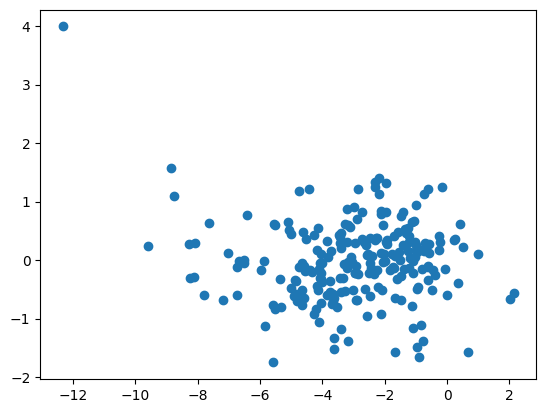

In [45]:
# 잔차 플랏
resid = y_test - y_pred

plt.scatter(y_pred, resid)
plt.show()

In [46]:
# # RFE 실행 (최종적으로 10개의 특성 선택)
# num_features = [3, 5, 7, 10, 20]
# for i in num_features:
#     rfe = RFE(estimator=optimal_elastic_net, n_features_to_select= i)
#     rfe.fit(X_train, y_train)

#     # RFE로 선택된 특성 이름 확인
#     selected_features_indices = rfe.support_
#     selected_features_names = X.columns[selected_features_indices]
#     print("최종 선택된 특성:", list(selected_features_names))

# # # 최종 선택된 특성으로 데이터프레임 생성
# # df_final_selected = ISIS_df[selected_features_names.tolist() + ['target']]
# # print("최종 데이터프레임:")
# # print(df_final_selected.head())